# Real Time Inference Endpoints

Setup constants used in the rest of the notebook. Pay particular attention to providing the right path for model on S3.

In [28]:
import sagemaker
from sagemaker import get_execution_role
import glob
import random
import shutil

role = get_execution_role()
sess = sagemaker.Session()

account = sess.account_id()
region = sess.boto_region_name
bucket = sess.default_bucket()

# Constants
# make sure the model path is updated with a valid model output from previous steps
prefix = 'BIRD-Sagemaker-Deployment'
MODEL_PATH = f"s3://{bucket}/{prefix}/BIRD-Sagemaker-RealTime-2022-05-25-17-35-45-784/output/model.tar.gz"
TF_FRAMEWORK_VERSION = '2.4.1'
ENDPOINT_INSTANCE_TYPE='ml.c5.4xlarge'

# Deploy Model

Create a TensorFlowModel from a model artifact on S3 and deploy to an endpoint. The endpoint name will be displayed when it's active and can be seen in the console as well.

In [8]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(
    model_data=MODEL_PATH,
    role=role,
    framework_version=TF_FRAMEWORK_VERSION)


predictor = model.deploy(initial_instance_count=1, instance_type=ENDPOINT_INSTANCE_TYPE)
tf_endpoint_name = str(predictor.endpoint_name)
print(f"Endpoint [{predictor.endpoint_name}] deployed")

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

The endpoint name will be displayed when it's active and can be seen in the console as well.

![Active Endpoint](statics/active-sagemaker-endpoints.png)

# Test Model

The `cv_utils` module creates wrappers around getting data for testing and doing predictions. Since it's a local module, use autoreload so latest changes are seen when developing

In [11]:
%load_ext autoreload
%autoreload 1
%aimport cv_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First we recreate the predictor from the endpoint name for sake of example. This can be skipped if the above cells were ran to deploy the endpoint but is needed if you want to test on an existing endpoint.

Serializer/deserializer indicates that we are sending image data to the endpoint and receiving JSON as a response

In [3]:
from sagemaker import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

tf_endpoint_name='tensorflow-inference-2022-05-25-19-44-00-852'
serializer = IdentitySerializer(content_type="application/x-image")
deserializer = JSONDeserializer(accept='application/json')

predictor = Predictor(endpoint_name=tf_endpoint_name,serializer = serializer,deserializer = deserializer )

The model used in this sample was **only trained on classes 13, 17, 35, 36, 47, 68, 73, 87** so we can only get predictions for those. Here we get the names of those classes to see what we can predict.

In [52]:
import cv_utils

classes_file = f"s3://{bucket}/{prefix}/full/data/classes.txt"
classes = [13, 17, 35, 36, 47, 68, 73, 87]

possible_classes= cv_utils.get_classes_as_list(classes_file,classes)

possible_classes

['013.Bobolink',
 '017.Cardinal',
 '035.Purple_Finch',
 '036.Northern_Flicker',
 '047.American_Goldfinch',
 '068.Ruby_throated_Hummingbird',
 '073.Blue_Jay',
 '087.Mallard']

Download N random images (from a set of image classes that match the classes the model was trained on) locally that we will use for sample predictions

In [50]:
sample_images = cv_utils.get_n_random_images(bucket,prefix=f'{prefix}/outputs/test',n=2)

local_paths = cv_utils.download_images_locally(bucket,sample_images)
print(local_paths)


./inference-test-data/Blue_Jay_0055_61507.jpg
./inference-test-data/Ruby_Throated_Hummingbird_0126_57371.jpg
['./inference-test-data/Blue_Jay_0055_61507.jpg', './inference-test-data/Ruby_Throated_Hummingbird_0126_57371.jpg']


Get predictions from the local images

./inference-test-data/Blue_Jay_0055_61507.jpg


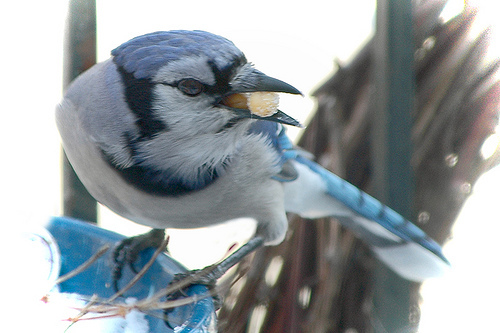

Class: 073.Blue_Jay, confidence: 1.00
./inference-test-data/Ruby_Throated_Hummingbird_0126_57371.jpg


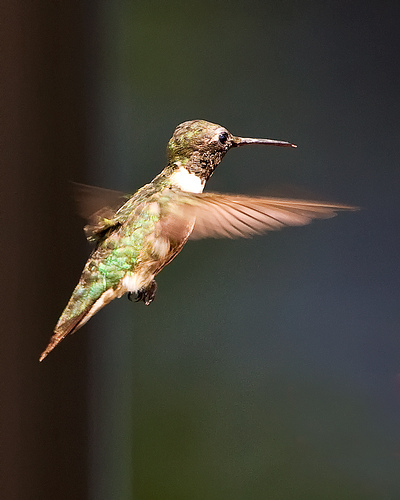

Class: 068.Ruby_throated_Hummingbird, confidence: 1.00


In [55]:
for inputfile in local_paths:
    print(inputfile)
    cv_utils.predict_bird_from_file(inputfile,predictor,possible_classes)